In [1]:
import numpy as np
caffe_root = '../../'
import sys
sys.path.insert(0, caffe_root+'python')
import caffe

caffe.set_mode_gpu()
net = caffe.Net('deploy.prototxt','../nin_base.caffemodel', caffe.TEST)

In [3]:
labels = open('/storage/datasets/ILSVRC2012/synset_words.txt').readlines()
#labels = [ for label in labels]
print labels

['n01440764 tench, Tinca tinca\n', 'n01443537 goldfish, Carassius auratus\n', 'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias\n', 'n01491361 tiger shark, Galeocerdo cuvieri\n', 'n01494475 hammerhead, hammerhead shark\n', 'n01496331 electric ray, crampfish, numbfish, torpedo\n', 'n01498041 stingray\n', 'n01514668 cock\n', 'n01514859 hen\n', 'n01518878 ostrich, Struthio camelus\n', 'n01530575 brambling, Fringilla montifringilla\n', 'n01531178 goldfinch, Carduelis carduelis\n', 'n01532829 house finch, linnet, Carpodacus mexicanus\n', 'n01534433 junco, snowbird\n', 'n01537544 indigo bunting, indigo finch, indigo bird, Passerina cyanea\n', 'n01558993 robin, American robin, Turdus migratorius\n', 'n01560419 bulbul\n', 'n01580077 jay\n', 'n01582220 magpie\n', 'n01592084 chickadee\n', 'n01601694 water ouzel, dipper\n', 'n01608432 kite\n', 'n01614925 bald eagle, American eagle, Haliaeetus leucocephalus\n', 'n01616318 vulture\n', 'n01622779 great gr

In [3]:
def makeLabelKeyDict(MAX_COUNT=100) :
    dic = {}
    count = [];
    for i in range(0,1000):
        dic[i] = []
        count.append(0)
    check_count = 0;
    
    import lmdb
    env = lmdb.open('/storage/datasets/ILSVRC2012/train_lmdb')
    with env.begin() as txn:
        cursor = txn.cursor()
        for key,value in cursor : 
            datum = caffe.proto.caffe_pb2.Datum()
            datum.ParseFromString(value)
            dic[datum.label].append(key)
            count[datum.label] = count[datum.label] + 1;
            check_count = (check_count + 1) % (MAX_COUNT * 2);
            if( check_count == 0 and min(count) > MAX_COUNT ) :
                break;
    return dic

label_key = makeLabelKeyDict(MAX_COUNT = 30)

In [4]:
def getImage(key):
    caffe_root = '../../'
    import lmdb
    
    imgs = [];
    
    img = np.zeros([256,256,3],np.uint8);
    env = lmdb.open('/storage/datasets/ILSVRC2012/train_lmdb')
    with env.begin() as txn:
        cursor = txn.cursor()
        value = cursor.get(key)
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        
        label = datum.label
        temp = np.fromstring(datum.data,dtype=np.uint8).reshape(3,256,256)
        img[:,:,0] = temp[2,:,:];
        img[:,:,1] = temp[1,:,:];
        img[:,:,2] = temp[0,:,:];
        
    return (label,img)

def getActivation(keys):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.load('./imagenet_mean.npy').mean(1).mean(1)) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    
    ret = {};
    ret['raw'] = {'loss' : np.zeros((len(keys),1000)), 'pool4' : np.zeros((len(keys),1000))}
    ret['avg'] = {'loss' : np.zeros(1000), 'pool4' : np.zeros(1000)}
    for i in range(0,len(keys),10):
        data = [];
        cnt = min(i+10,len(keys))-i;
        for j in range(i,i+cnt):
            label,raw = getImage(keys[j]);
            data.append(transformer.preprocess('data',raw))
        ret['raw']['loss'][i:i+cnt,:] = net.forward_all(data=np.asarray(data))['loss'].reshape(cnt,1000)
        ret['raw']['pool4'][i:i+cnt,:] = net.blobs['pool4'].data[0:cnt,:,:,:].reshape(cnt,1000)
    ret['avg']['pool4'] = np.sum(ret['raw']['pool4'],axis=0) / len(keys)
    return ret


In [ ]:
activations = np.zeros((1000,1000),np.float);
for i in range(0,1000):
    activations[i,:] = getActivation(label_key[i][0:20])['avg']['pool4'];
    print i, 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [6]:
#np.save('activations.aa',activations)
# import numpy as np
# activations = np.load('activations.aa.npy')

import sklearn.cluster as clu
NUM_CLUSTER = 300

from sklearn.neighbors import kneighbors_graph
#connectivity = kneighbors_graph(activations, n_neighbors=5)

#ward = clu.AgglomerativeClustering(n_clusters=NUM_CLUSTER,connectivity=connectivity).fit(activations)
ward = clu.AgglomerativeClustering(n_clusters=NUM_CLUSTER).fit(activations)
super_category = ward.labels_
for i in range(0,NUM_CLUSTER):
    for j in range(0,1000):
        if super_category[j] == i:
            print labels[j], 
    print

for i in range(0,NUM_CLUSTER):
    print 'children {'
    for j in range(0,1000):
        if super_category[j] == i:
            print '\tchildren {\n\t\tlabel:%d #%s\n\t}'%(j,labels[j])
    print '}'

n01629819 European fire salamander, Salamandra salamandra
n01630670 common newt, Triturus vulgaris
n01631663 eft
n01632458 spotted salamander, Ambystoma maculatum
n02317335 starfish, sea star

n02917067 bullet train, bullet
n02930766 cab, hack, taxi, taxicab
n03459775 grille, radiator grille
n04285008 sports car, sport car

n01751748 sea snake
n01917289 brain coral
n01924916 flatworm, platyhelminth
n01950731 sea slug, nudibranch
n01955084 chiton, coat-of-mail shell, sea cradle, polyplacophore
n02321529 sea cucumber, holothurian
n02526121 eel
n02655020 puffer, pufferfish, blowfish, globefish

n02776631 bakery, bakeshop, bakehouse
n02927161 butcher shop, meat market
n04111531 rotisserie

n03425413 gas pump, gasoline pump, petrol pump, island dispenser
n03710193 mailbox, letter box
n03902125 pay-phone, pay-station
n04243546 slot, one-armed bandit
n04525305 vending machine

n02100877 Irish setter, red setter
n02102480 Sussex spaniel
n02108551 Tibetan mastiff

n03126707 crane
n03447447 gond

00000564_n01693334/n01693334_397.JPEG


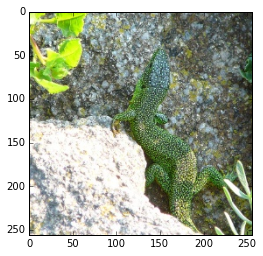

n01693334 green lizard, Lacerta viridis
n01693334 green lizard, Lacerta viridis



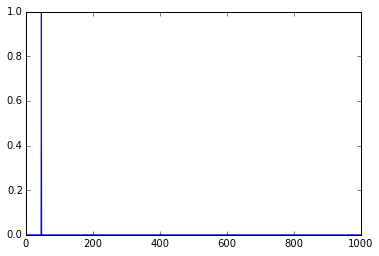

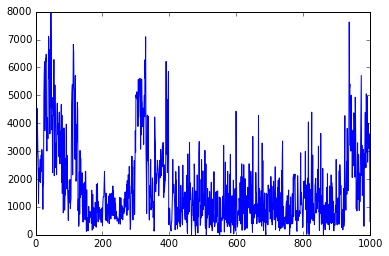

00001156_n01693334/n01693334_10339.JPEG


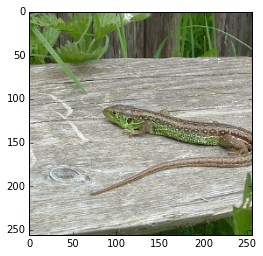

n01693334 green lizard, Lacerta viridis
n02808304 bath towel



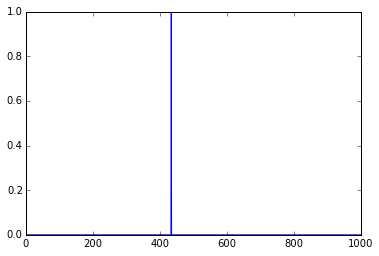

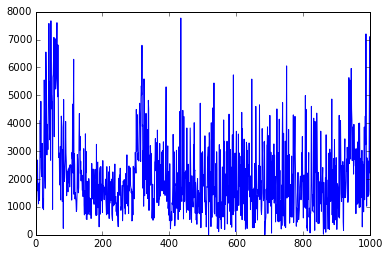

00001605_n01693334/n01693334_282.JPEG


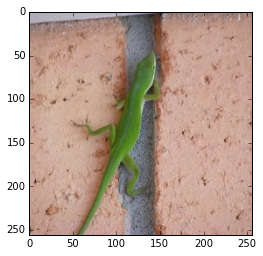

n01693334 green lizard, Lacerta viridis
n01693334 green lizard, Lacerta viridis



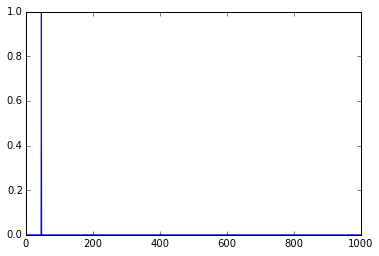

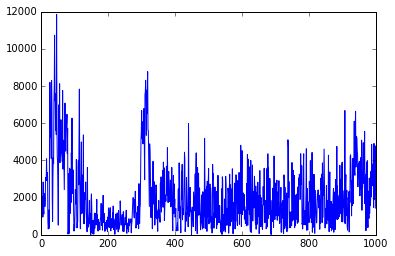

00003078_n01693334/n01693334_21383.JPEG


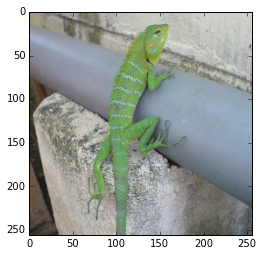

n01693334 green lizard, Lacerta viridis
n03627232 knot



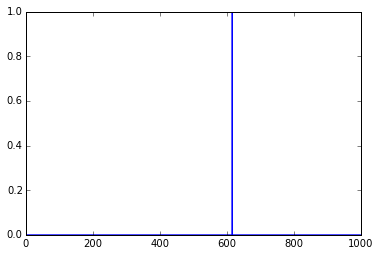

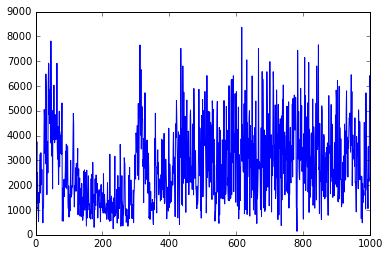

00006653_n01693334/n01693334_11557.JPEG


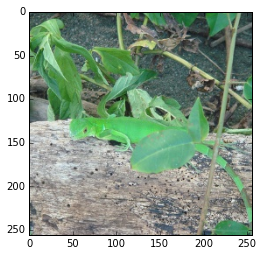

n01693334 green lizard, Lacerta viridis
n01677366 common iguana, iguana, Iguana iguana



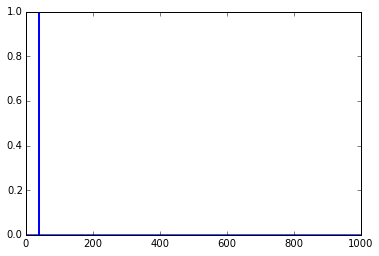

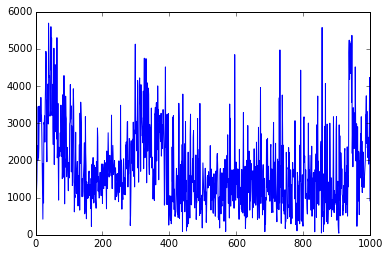

00007564_n01693334/n01693334_8908.JPEG


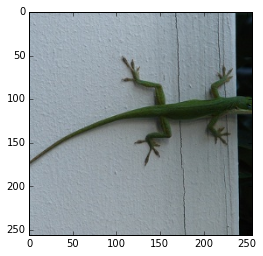

n01693334 green lizard, Lacerta viridis
n01682714 American chameleon, anole, Anolis carolinensis



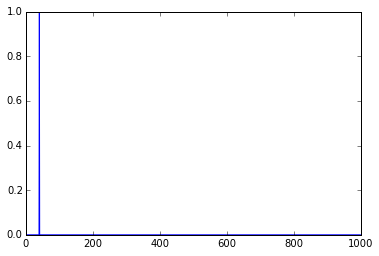

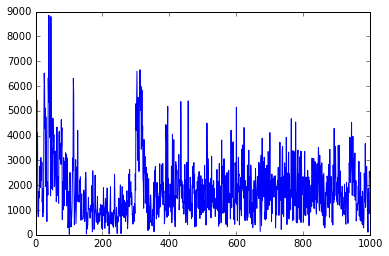

00007782_n01693334/n01693334_16451.JPEG


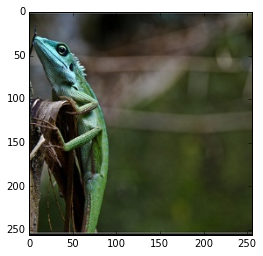

n01693334 green lizard, Lacerta viridis
n01693334 green lizard, Lacerta viridis



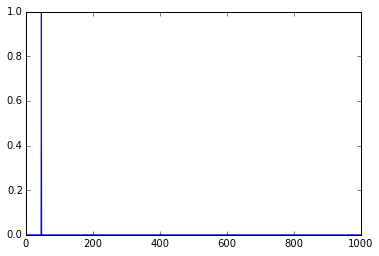

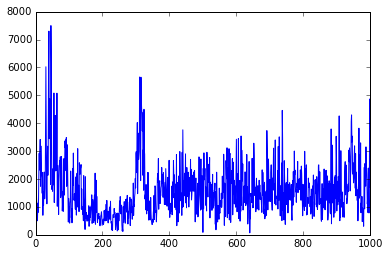

00007937_n01693334/n01693334_9937.JPEG


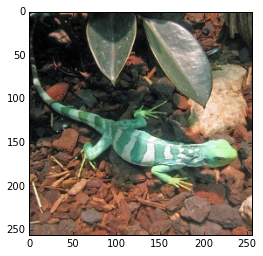

n01693334 green lizard, Lacerta viridis
n01704323 triceratops



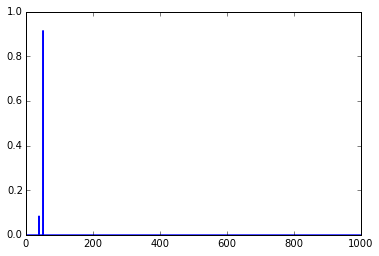

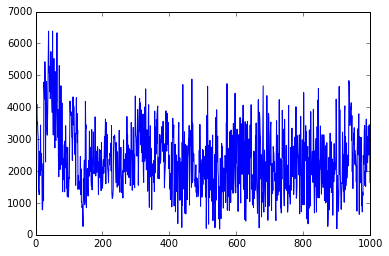

00011912_n01693334/n01693334_3624.JPEG


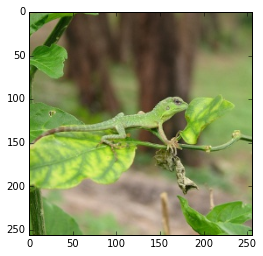

n01693334 green lizard, Lacerta viridis
n02226429 grasshopper, hopper



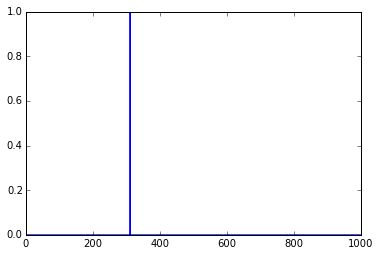

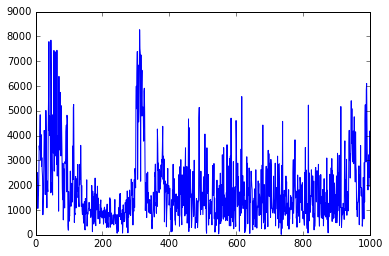

00012244_n01693334/n01693334_10062.JPEG


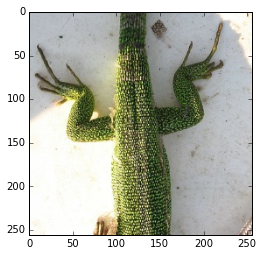

n01693334 green lizard, Lacerta viridis
n01693334 green lizard, Lacerta viridis



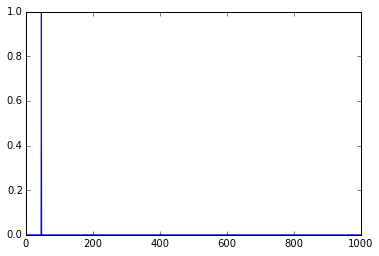

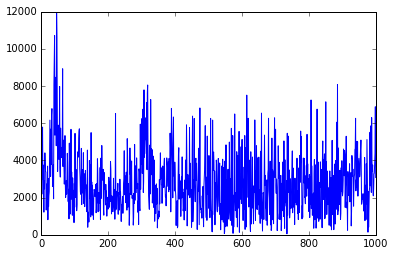

00012783_n01693334/n01693334_10441.JPEG


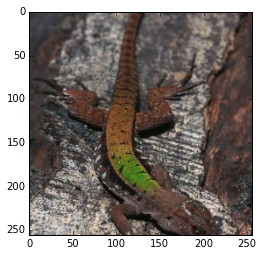

n01693334 green lizard, Lacerta viridis
n01682714 American chameleon, anole, Anolis carolinensis



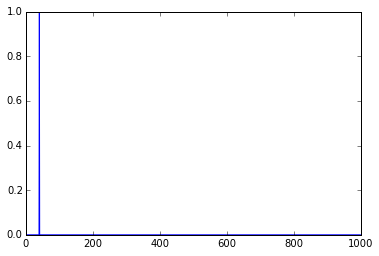

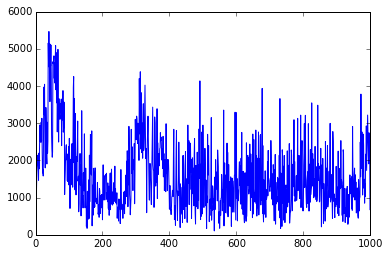

00012917_n01693334/n01693334_8154.JPEG


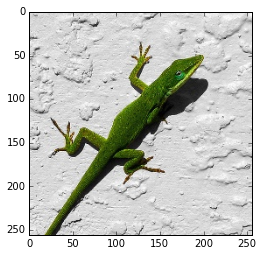

n01693334 green lizard, Lacerta viridis
n01693334 green lizard, Lacerta viridis



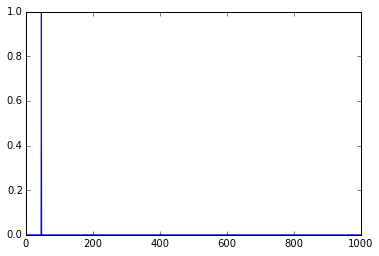

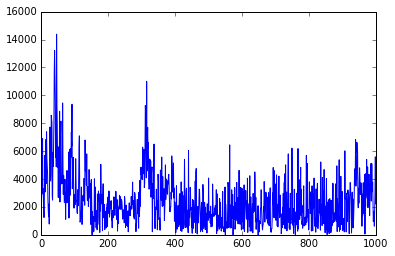

00013120_n01693334/n01693334_8736.JPEG


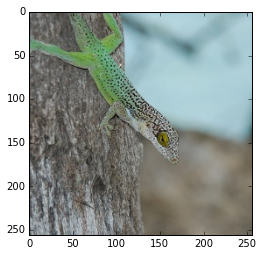

n01693334 green lizard, Lacerta viridis
n01682714 American chameleon, anole, Anolis carolinensis



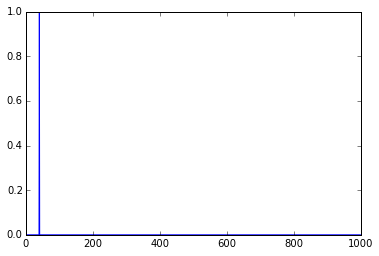

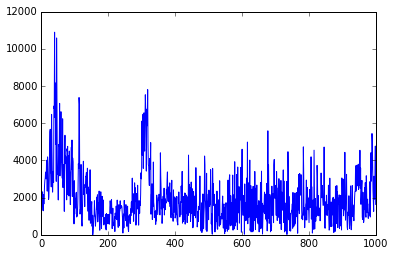

00013456_n01693334/n01693334_7694.JPEG


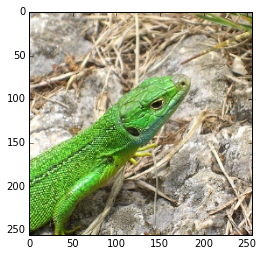

n01693334 green lizard, Lacerta viridis
n02264363 lacewing, lacewing fly



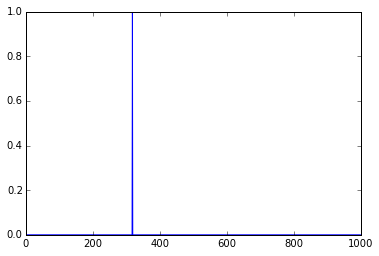

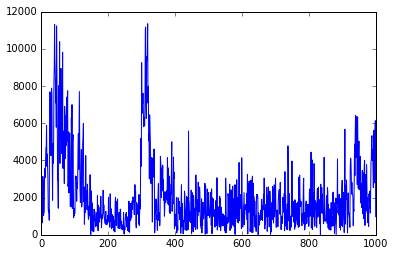

00014208_n01693334/n01693334_1881.JPEG


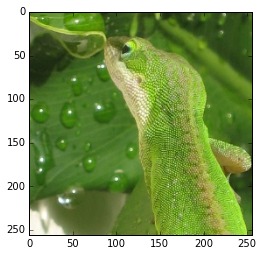

n01693334 green lizard, Lacerta viridis
n01644373 tree frog, tree-frog



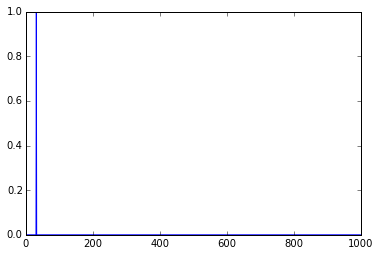

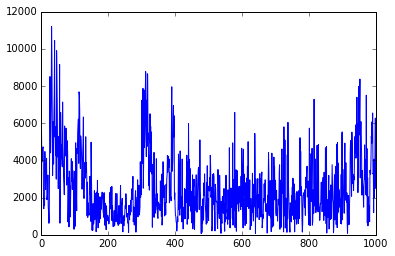

00014624_n01693334/n01693334_3501.JPEG


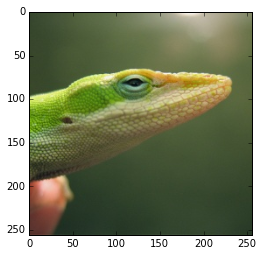

n01693334 green lizard, Lacerta viridis
n01682714 American chameleon, anole, Anolis carolinensis



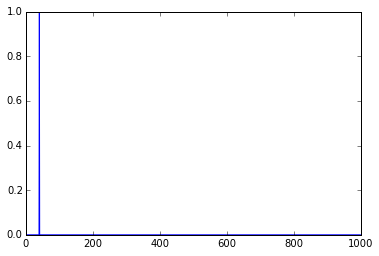

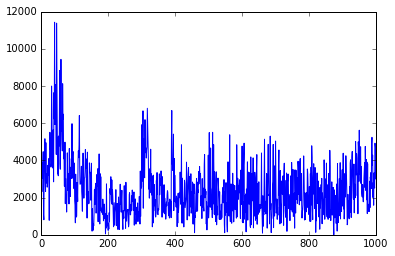

00015720_n01693334/n01693334_4348.JPEG


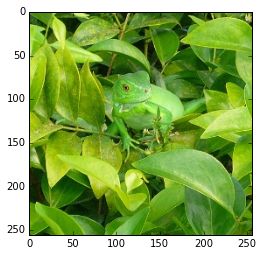

n01693334 green lizard, Lacerta viridis
n02281406 sulphur butterfly, sulfur butterfly



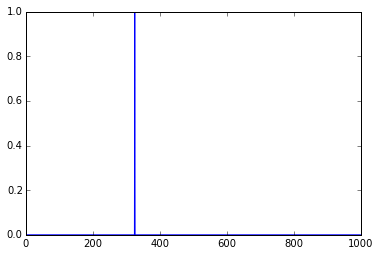

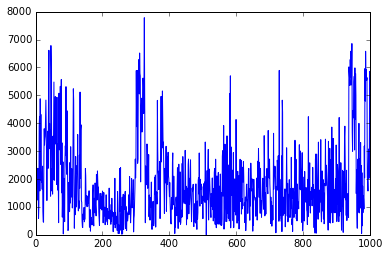

00016874_n01693334/n01693334_407.JPEG


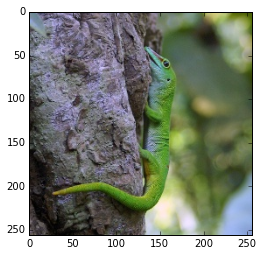

n01693334 green lizard, Lacerta viridis
n01729977 green snake, grass snake



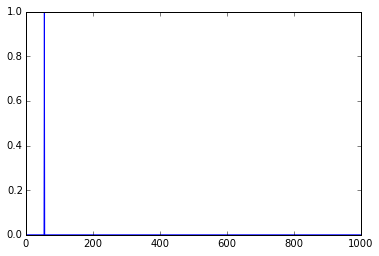

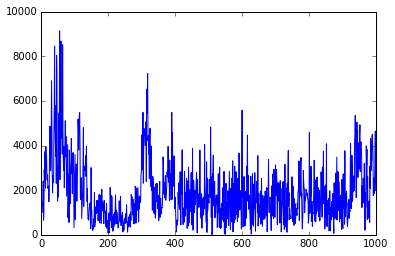

00017565_n01693334/n01693334_10381.JPEG


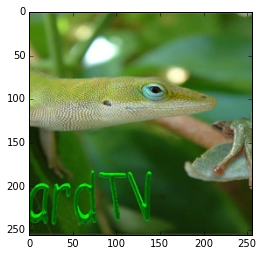

n01693334 green lizard, Lacerta viridis
n01729977 green snake, grass snake



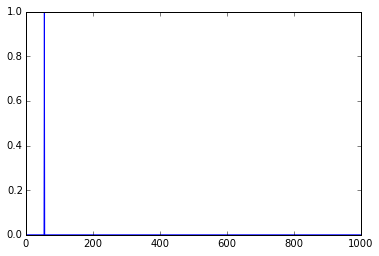

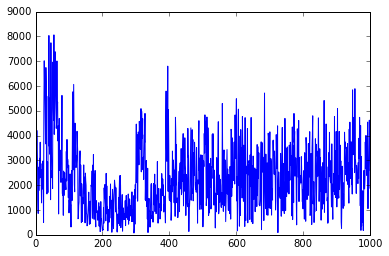

00022681_n01693334/n01693334_3708.JPEG


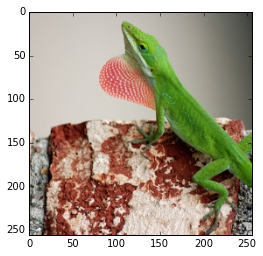

n01693334 green lizard, Lacerta viridis
n01682714 American chameleon, anole, Anolis carolinensis



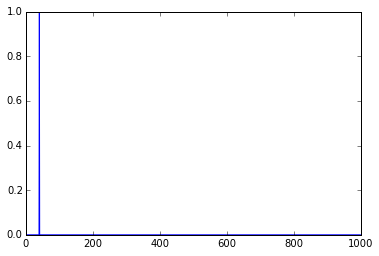

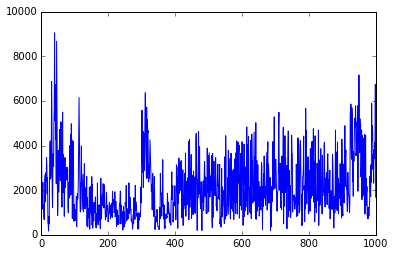

00023089_n01693334/n01693334_10059.JPEG


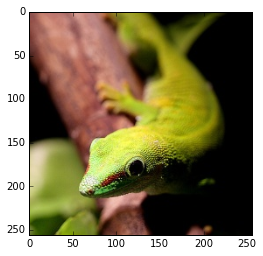

n01693334 green lizard, Lacerta viridis
n01644373 tree frog, tree-frog



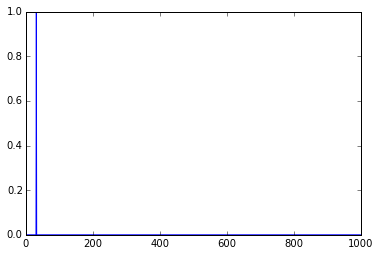

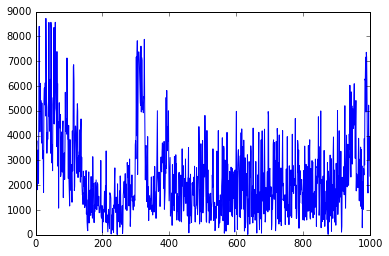

00023282_n01693334/n01693334_4319.JPEG


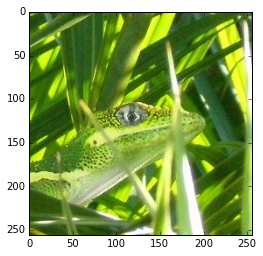

n01693334 green lizard, Lacerta viridis
n02226429 grasshopper, hopper



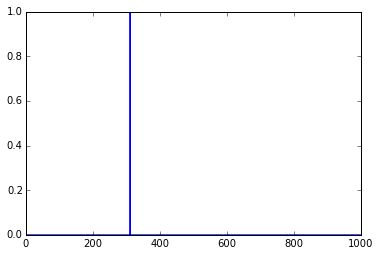

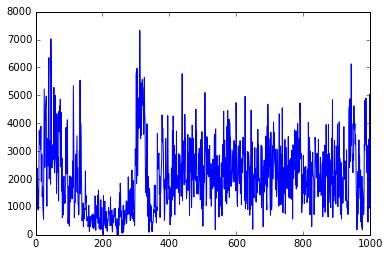

00023725_n01693334/n01693334_7440.JPEG


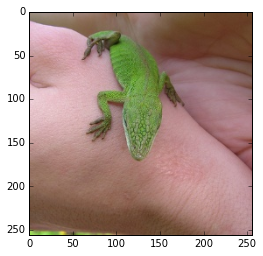

n01693334 green lizard, Lacerta viridis
n01644373 tree frog, tree-frog



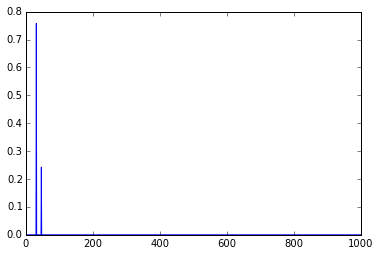

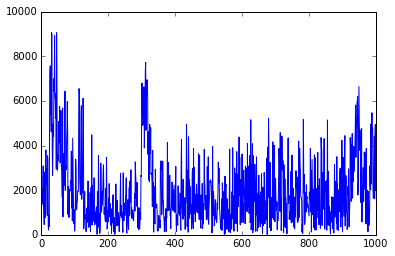

00024474_n01693334/n01693334_5670.JPEG


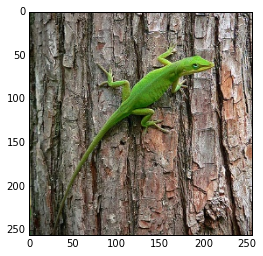

n01693334 green lizard, Lacerta viridis
n01682714 American chameleon, anole, Anolis carolinensis



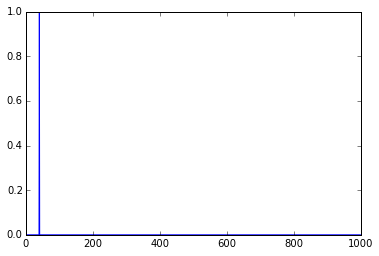

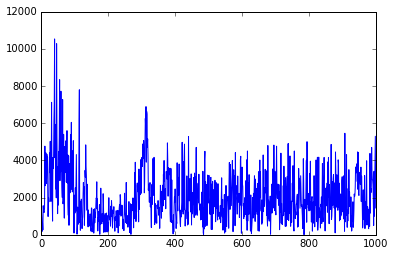

00025438_n01693334/n01693334_11540.JPEG


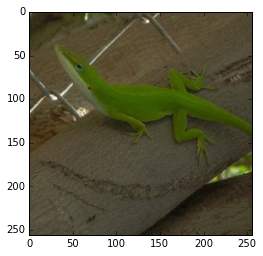

n01693334 green lizard, Lacerta viridis
n01677366 common iguana, iguana, Iguana iguana



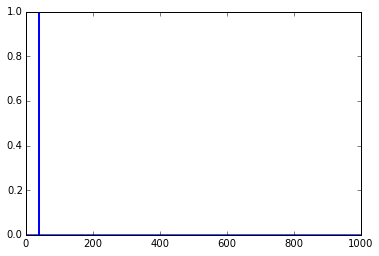

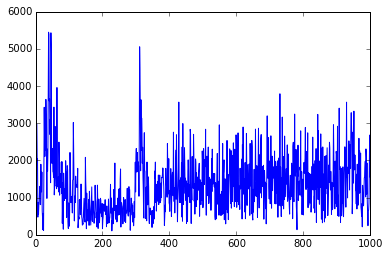

00025902_n01693334/n01693334_10651.JPEG


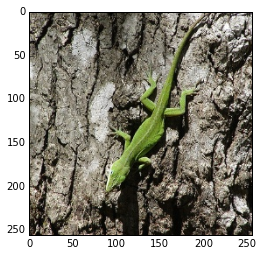

n01693334 green lizard, Lacerta viridis
n02236044 mantis, mantid



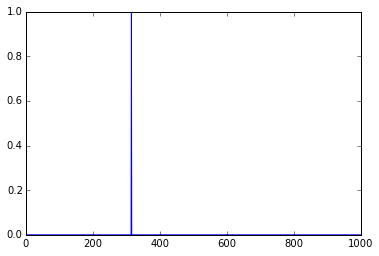

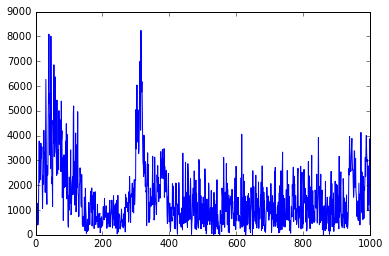

00026906_n01693334/n01693334_13543.JPEG


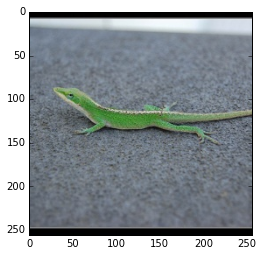

n01693334 green lizard, Lacerta viridis
n01693334 green lizard, Lacerta viridis



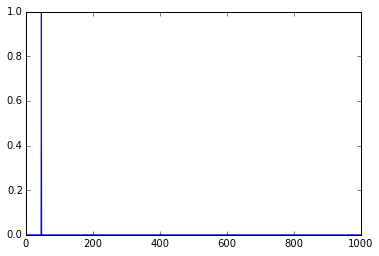

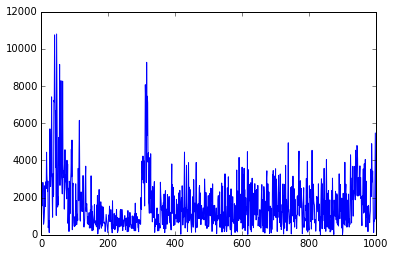

00028210_n01693334/n01693334_10354.JPEG


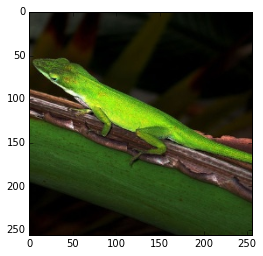

n01693334 green lizard, Lacerta viridis
n01682714 American chameleon, anole, Anolis carolinensis



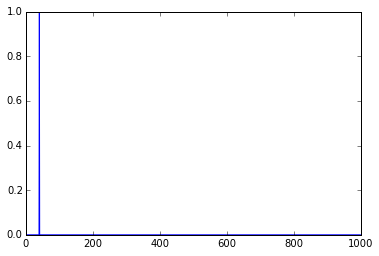

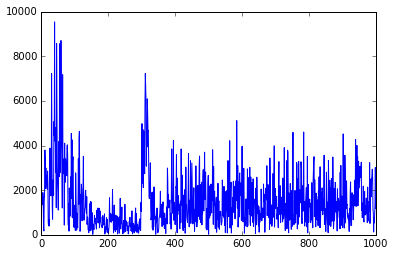

00029714_n01693334/n01693334_8102.JPEG


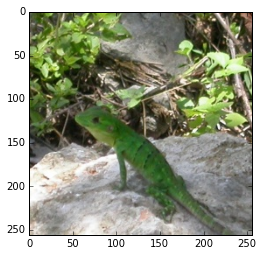

n01693334 green lizard, Lacerta viridis
n01677366 common iguana, iguana, Iguana iguana



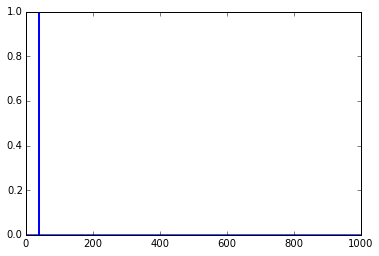

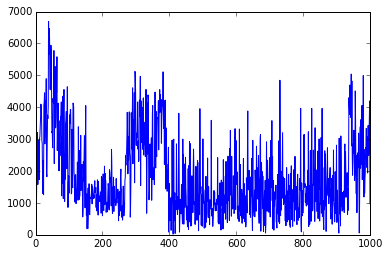

00031779_n01693334/n01693334_12664.JPEG


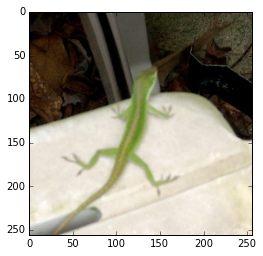

n01693334 green lizard, Lacerta viridis
n01693334 green lizard, Lacerta viridis



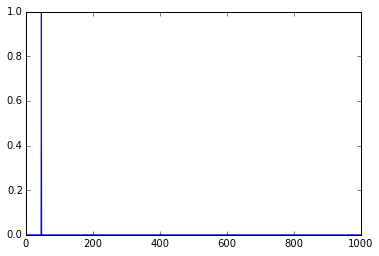

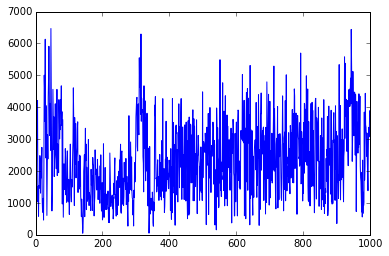

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

for i in range(0,30):
    l,im = getImage(label_key[46][i])
    print label_key[46][i]
    plt.imshow(im)
    plt.show()

    ret = getActivation(label_key[46][i:i+1])
    print labels[l], labels[ret['raw']['loss'].reshape(1000).argmax(axis=0)]
    plt.plot(ret['raw']['loss'].reshape(1000))
    plt.show()
    plt.plot(ret['raw']['pool4'].reshape(1000))
    plt.show()